# Time series analysis & forecasting 
Messing with time series analysis to see if it can predict anything about book scanning in the internet archive!
I'm following this tutorial: https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns      
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/ers6/ia_bols/main/scan-center-counts/hongkong_scan_counts.csv")

In [3]:
df

,month_year,books_scanned
0,2009-08,1
1,2009-09,2
2,2009-12,1
3,2010-02,1
4,2010-06,1
...,...,...
57,2018-09,26901
58,2018-10,29563
59,2018-11,26944
60,2018-12,19350


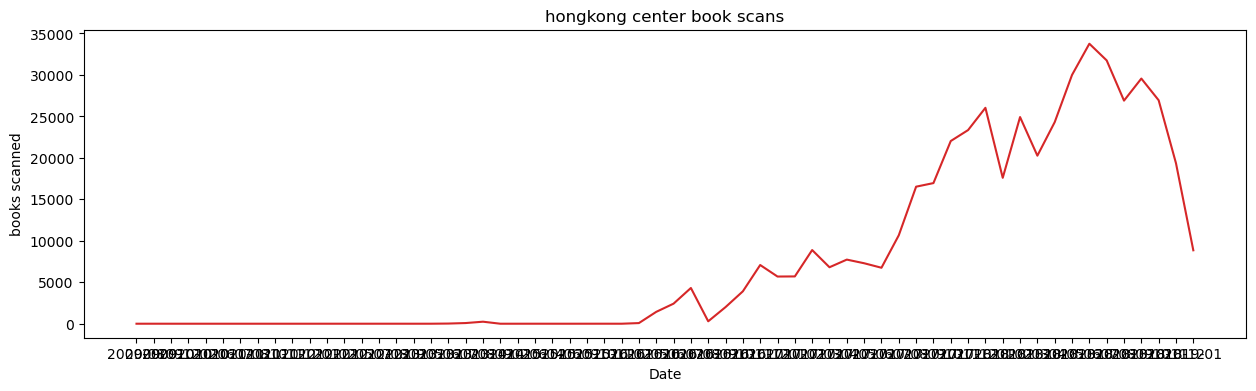

In [4]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='books scanned', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    

plot_df(df, x=df['month_year'], y=df['books_scanned'], title='hongkong center book scans')

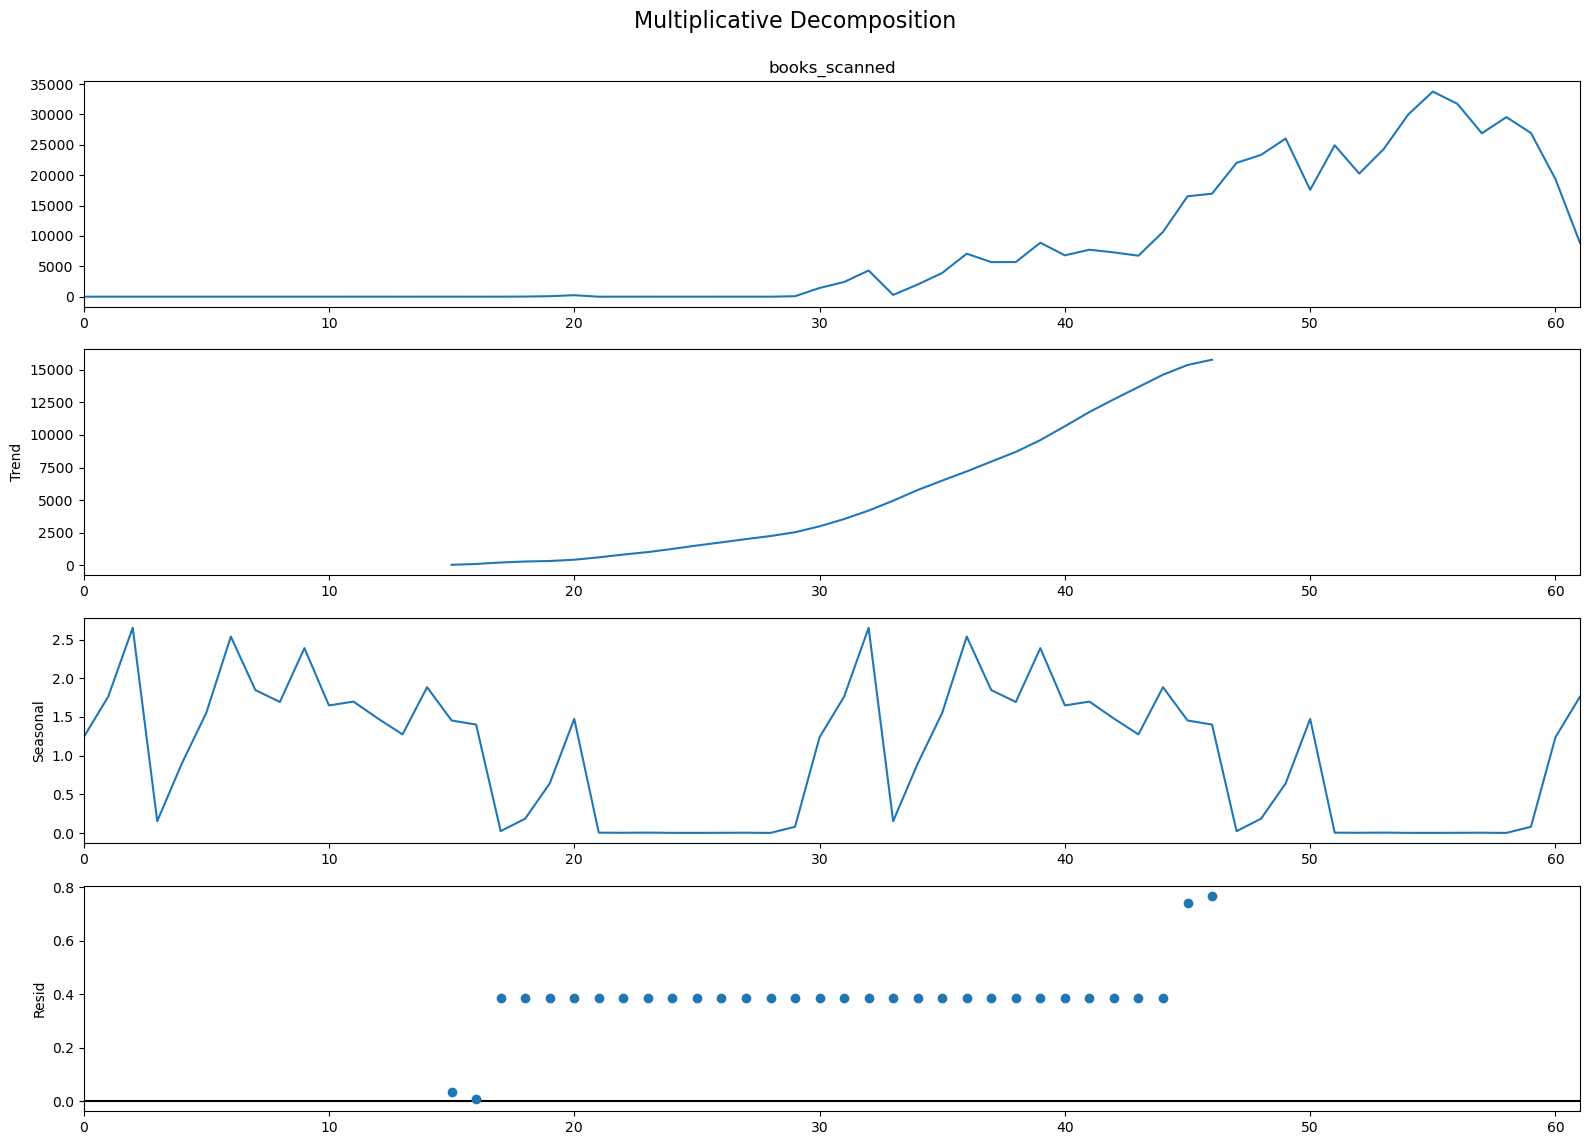

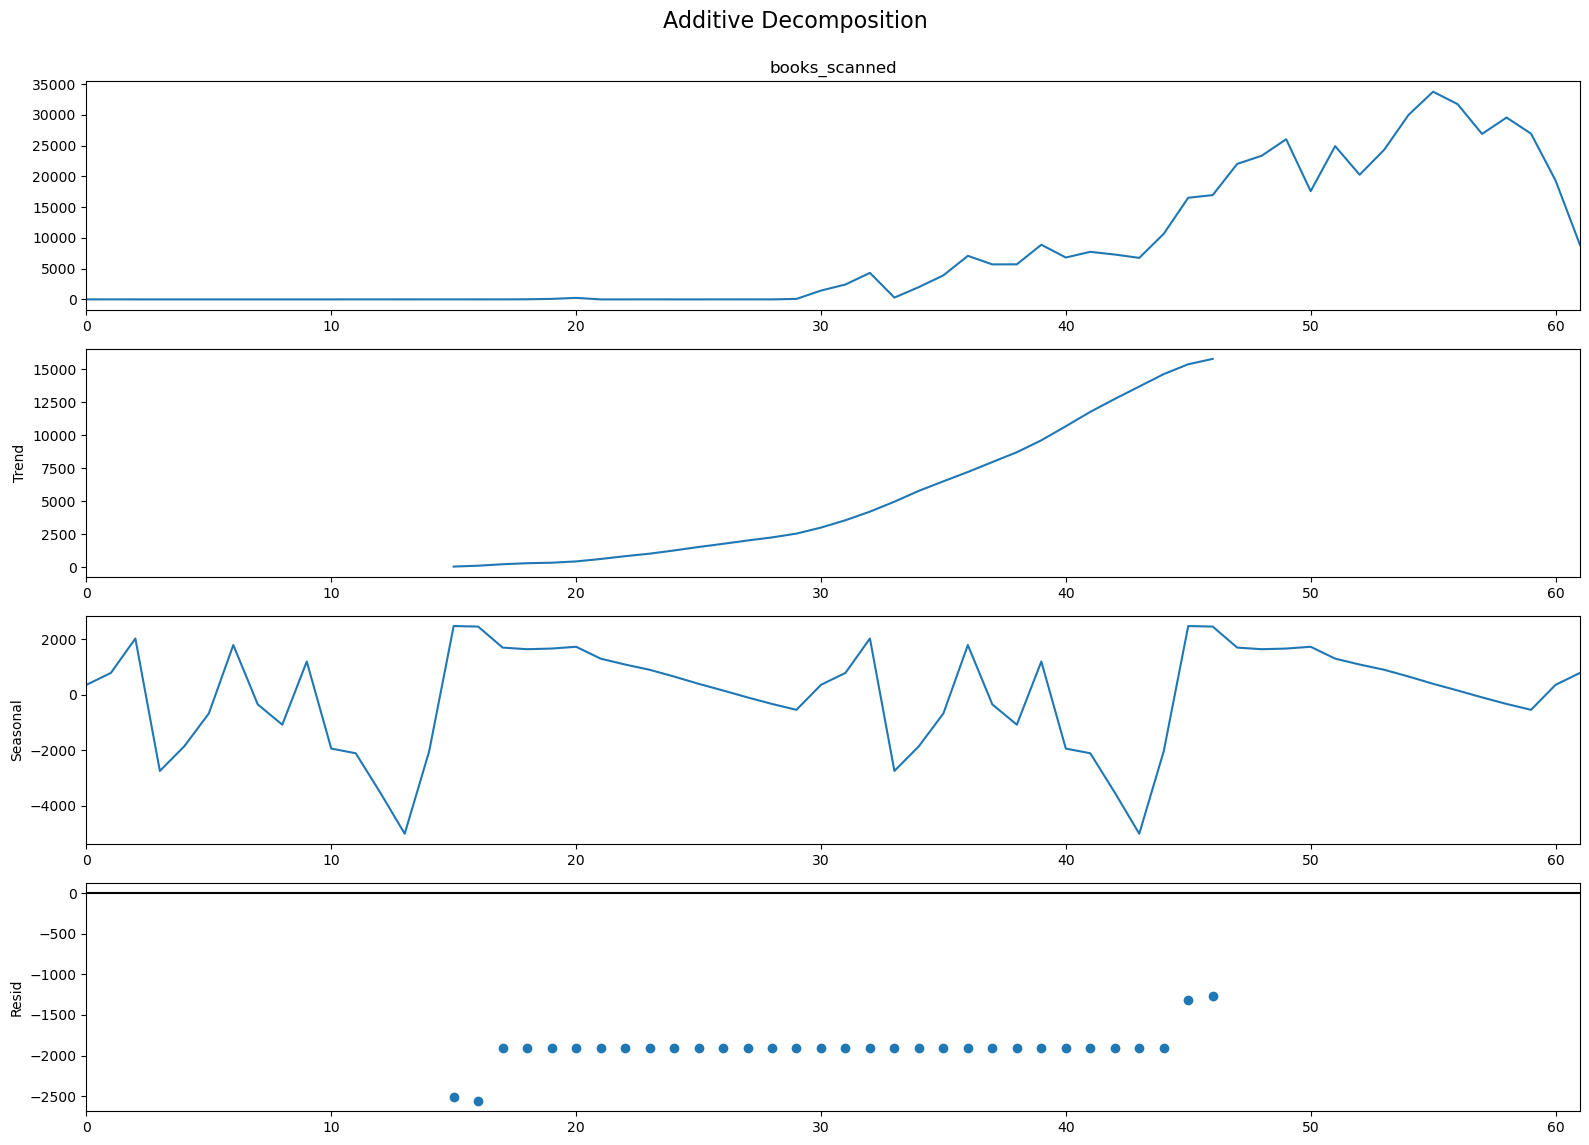

In [5]:
# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(df['books_scanned'], model='multiplicative', period=30)

# Additive Decomposition
additive_decomposition = seasonal_decompose(df['books_scanned'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

Text(0.5, 1.0, 'Air Passengers detrended by subtracting the least squares fit')

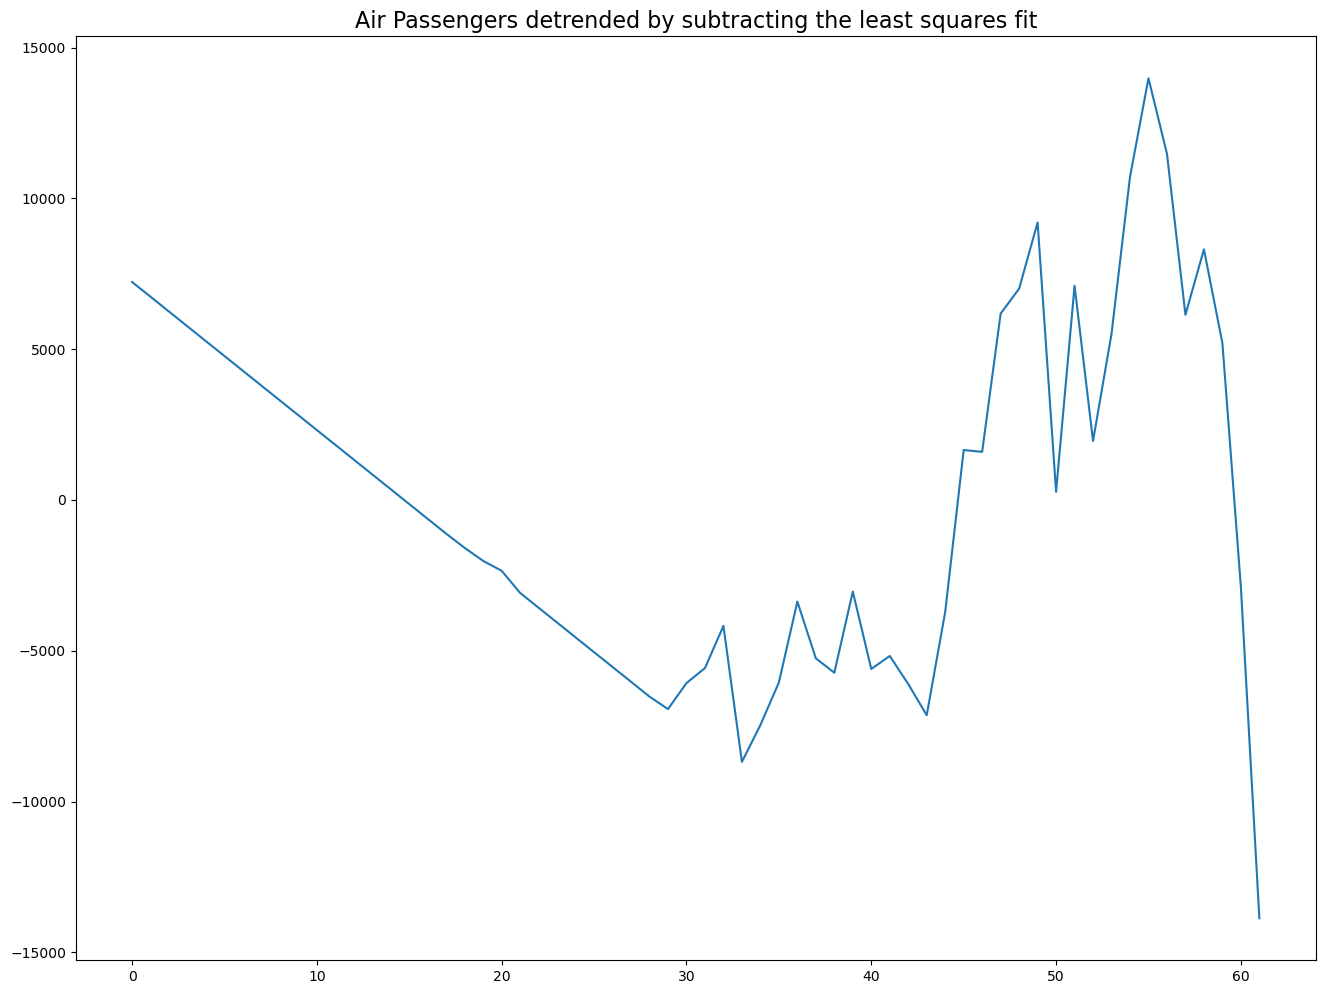

In [6]:
from scipy import signal
detrended = signal.detrend(df['books_scanned'].values)
plt.plot(detrended)
plt.title('Air Passengers detrended by subtracting the least squares fit', fontsize=16)


alright! well that was all pretty useless- perhaps we don't care so much about time in and of itself- there's obviously no seasonal relationship between book-scans and months--we woudln't really expect that. However, we would expect some kind of relationship to exist because the total weight of a shipping container in a month and the number of book scans. To study that, we need to merge together our shipping and scan counts data. I want to get a dataset of total weight of shipped goods per month. then, I want to smush that into the same dataframe as my book scan counts. 

Let's just do this with hongkong to start with because cebu gets odd halfway through and Shenzhen is a total wreck. 

In [7]:
hk_scan_per_month = pd.read_csv("https://raw.githubusercontent.com/ers6/ia_bols/main/scan-center-counts/hongkong_scan_counts.csv")

In [8]:
bols = pd.read_csv("https://raw.githubusercontent.com/ers6/ia_bols/main/geographic-data/bills-of-lading/combined_ia_bols_manual_dedupe%20-%20deduped_results.csv")

In [9]:
hk_bols = bols.loc[bols['supplier_location_id'] == 'veristrong_industrial']

In [10]:
hk_bols['arrival_date']

15    2017-02-13
16    2017-06-02
17    2017-09-29
18    2018-01-06
20    2018-02-23
21    2018-05-11
22    2018-07-06
23    2018-08-24
24    2018-10-11
25    2018-12-03
26    2019-01-20
27    2019-02-25
Name: arrival_date, dtype: object

In [11]:
hk_scan_per_month

,month_year,books_scanned
0,2009-08,1
1,2009-09,2
2,2009-12,1
3,2010-02,1
4,2010-06,1
...,...,...
57,2018-09,26901
58,2018-10,29563
59,2018-11,26944
60,2018-12,19350


In [12]:
# cebu_df['scandate'] = pd.to_datetime(cebu_df['scandate'], format='%Y%m%d%H%M%S')
# cebu_df['month_year'] = pd.to_datetime(cebu_df['scandate']).dt.to_period('M')
# cebu_scan_counts = cebu_df.groupby(cebu_df['month_year']).count()
hk_bols['arrival_date'] = pd.to_datetime(hk_bols['arrival_date'], format='%Y-%m-%d')

/var/folders/pl/rjmtml311bq31fb0njd03xlh0000gn/T/ipykernel_20752/2466811380.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_bols['arrival_date'] = pd.to_datetime(hk_bols['arrival_date'], format='%Y-%m-%d')


In [13]:
hk_bols['arrival_date'] = pd.to_datetime(hk_bols['arrival_date']).dt.to_period('M').astype('str')
# cebu_df['month_year'] = pd.to_datetime(cebu_df['scandate']).dt.to_period('M')

/var/folders/pl/rjmtml311bq31fb0njd03xlh0000gn/T/ipykernel_20752/319001600.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hk_bols['arrival_date'] = pd.to_datetime(hk_bols['arrival_date']).dt.to_period('M').astype('str')


In [14]:
hk_ships = hk_bols[['arrival_date', 'weight_kg']]

In [15]:
hk_ships

,arrival_date,weight_kg
15,2017-02,10390
16,2017-06,17845
17,2017-09,18250
18,2018-01,13420
20,2018-02,14310
21,2018-05,16110
22,2018-07,16650
23,2018-08,16160
24,2018-10,16510
25,2018-12,19316


In [16]:
hk_scan_per_month

,month_year,books_scanned
0,2009-08,1
1,2009-09,2
2,2009-12,1
3,2010-02,1
4,2010-06,1
...,...,...
57,2018-09,26901
58,2018-10,29563
59,2018-11,26944
60,2018-12,19350


In [17]:
# pd.concat(
#     objs,
#     axis=0,
#     join="outer",
#     ignore_index=False,
#     keys=None,
#     levels=None,
#     names=None,
#     verify_integrity=False,
#     copy=True,
# )

hk_scan_per_month['month_year'].unique()

array(['2009-08', '2009-09', '2009-12', '2010-02', '2010-06', '2010-07',
       '2011-08', '2011-10', '2011-11', '2011-12', '2012-01', '2012-02',
       '2012-05', '2012-07', '2012-08', '2012-09', '2013-05', '2013-06',
       '2013-07', '2013-08', '2013-09', '2014-02', '2014-06', '2015-04',
       '2015-06', '2015-09', '2015-10', '2015-11', '2016-02', '2016-05',
       '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11',
       '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05',
       '2017-06', '2017-07', '2017-08', '2017-09', '2017-10', '2017-11',
       '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05',
       '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11',
       '2018-12', '2019-01'], dtype=object)

In [18]:
dfinal = hk_scan_per_month.merge(hk_ships, how='outer', left_on='month_year', right_on='arrival_date')

In [19]:
dfinal.fillna('')

,month_year,books_scanned,arrival_date,weight_kg
0,2009-08,1.0,NaN,NaN
1,2009-09,2.0,NaN,NaN
2,2009-12,1.0,NaN,NaN
3,2010-02,1.0,NaN,NaN
4,2010-06,1.0,NaN,NaN
...,...,...,...,...
58,2018-10,29563.0,2018-10,16510.0
59,2018-11,26944.0,NaN,NaN
60,2018-12,19350.0,2018-12,19316.0
61,2019-01,8855.0,2019-01,20660.0


In [32]:
i = 0

for entry in range(len(dfinal)):
    if dfinal.iloc[i]['month_year'] == np.nan:
        print('potato')
    i +=1

In [31]:
type(dfinal.iloc[62]['month_year'])

float